In [9]:
from captcha.image import ImageCaptcha
from matplotlib import pyplot as plt
import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
%matplotlib inline


In [6]:
#image = ImageCaptcha(fonts=['./font/AntykwaBold.ttf', './font/Candice.ttf', './font/VeraMono.ttf', './font/verdana.ttf'])


In [2]:
# %%timeit
# X = []
# for i in range(1000):
#     text = ''.join(random.sample(char_map, 4))
#     img = np.array(image.generate_image(text).resize((100, 40)))
#     img_gray = np.mean(img, -1)
#     if not isinstance(X, np.ndarray):
#         X = img_gray[..., np.newaxis]
#     else:
#         X = np.concatenate((X, img_gray[..., np.newaxis]), axis=-1)
#     #灰度值求解
#     #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
#     if i % 100 == 0:
#         print("generating captcha " , i)

num_char = 4
num_images = 10000
width_images = 100
height_images = 40
num_charmap = 36
num_channel = 1
char_map = string.ascii_uppercase + string.digits

num_images_test = 500


image_generator = ImageCaptcha(fonts=['./font/AntykwaBold.ttf'])

def dataset_generator(num_images):
    X = np.empty((num_images, height_images, width_images))
    y = np.empty((num_images, num_charmap*num_char))
    for i in range(num_images):
        text = ''.join(random.sample(char_map, num_char))
        img = np.array(image_generator.generate_image(text).resize((width_images, height_images)))
        img_gray = np.mean(img, -1)
        img_scale = np.multiply(img_gray, 1/255.0)
        X[i, :, :] = img_scale
        y_index = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
        y[i, y_index] = 1

        #灰度值求解
        #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
        if i % (num_images/5) == 0:
            print("generating captcha " , i)
    return X, y

print("generate train dataset: \n", '-'*40)
X_train, y_train = dataset_generator(num_images)
print("generate test dataset: \n", '-'*40)
X_test, y_test = dataset_generator(num_images_test)
        
def generator(X, y, batch_size=100):
    index_in_epoch = 0
    while True:
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_images:
            perm = np.arange(num_images)
            np.random.shuffle(perm)
            X = X[perm]
            y = y[perm]
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_images
        end = index_in_epoch
        yield X[start:end], y[start:end]     


generate train dataset: 
 ----------------------------------------
generating captcha  0
generating captcha  2000
generating captcha  4000
generating captcha  6000
generating captcha  8000
generate test dataset: 
 ----------------------------------------
generating captcha  0
generating captcha  100
generating captcha  200
generating captcha  300
generating captcha  400


In [5]:
import tensorflow as tf
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, height_images, width_images])
y_ = tf.placeholder(tf.float32, shape=[None, num_char*num_charmap])

In [12]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1, height_images, width_images, 1])

#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#Third Convolutional Layer
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool3 = max_pool_2x2(h_conv2)

#First densely Connected Layer
W_fc1 = weight_variable([10 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 144])
b_fc2 = bias_variable([144])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


#cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
#分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数
cross_entropy = tf.reduce_mean(
    tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
        y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
                  for i in range(num_char) ]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.cast([tf.equal(tf.argmax(y_conv[:, num_charmap*i:num_charmap*(i+1)-1],1),
           tf.argmax(y_[:, num_charmap*i:num_charmap*(i+1)-1],1)) for i in range(num_char)] , tf.float32)
accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=0))
sess.run(tf.global_variables_initializer())

trainset_ge = generator(X_train, y_train, batch_size=64)
num_loop = 10000
print(time.ctime() ,": train cnn begin, amount %d steps"%num_loop)
for i in range(num_loop):
    X_batch, y_batch = next(trainset_ge)
    if (i+1)/(num_loop/10) == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}))

Thu Jan  5 15:49:23 2017 : train cnn begin, amount 10000 steps


KeyboardInterrupt: 

In [10]:
#lost function 1 test
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_1)
sess.run(tf.global_variables_initializer())

trainset_ge = generator(X_train, y_train, batch_size=64)
X_batch, y_batch = next(trainset_ge)
num_loop = 1000
for i in range(num_loop):
    if (i+1)%(num_loop/10) == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}))

Thu Jan  5 14:52:36 2017 : step 0, training accuracy 0
Thu Jan  5 14:55:23 2017 : step 100, training accuracy 0
Thu Jan  5 14:58:10 2017 : step 200, training accuracy 0
Thu Jan  5 15:00:54 2017 : step 300, training accuracy 0
Thu Jan  5 15:03:48 2017 : step 400, training accuracy 0
Thu Jan  5 15:06:28 2017 : step 500, training accuracy 0
Thu Jan  5 15:09:01 2017 : step 600, training accuracy 0
Thu Jan  5 15:11:28 2017 : step 700, training accuracy 0
Thu Jan  5 15:13:56 2017 : step 800, training accuracy 0
Thu Jan  5 15:16:24 2017 : step 900, training accuracy 0
Thu Jan  5 15:18:58 2017 : test accuracy 0


In [11]:
#lost function 2 test
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_2)
sess.run(tf.global_variables_initializer())

trainset_ge = generator(X_train, y_train, batch_size=64)
X_batch, y_batch = next(trainset_ge)
num_loop = 1000
for i in range(num_loop):
    if (i+1)%(num_loop/10) == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}))

Thu Jan  5 15:22:57 2017 : step 99, training accuracy 0.125
Thu Jan  5 15:25:30 2017 : step 199, training accuracy 0.734375
Thu Jan  5 15:27:59 2017 : step 299, training accuracy 0.8125
Thu Jan  5 15:30:32 2017 : step 399, training accuracy 0.8125
Thu Jan  5 15:33:13 2017 : step 499, training accuracy 0.828125
Thu Jan  5 15:35:55 2017 : step 599, training accuracy 0.8125
Thu Jan  5 15:38:26 2017 : step 699, training accuracy 0.828125
Thu Jan  5 15:41:06 2017 : step 799, training accuracy 0.8125
Thu Jan  5 15:43:43 2017 : step 899, training accuracy 0.8125
Thu Jan  5 15:46:21 2017 : step 999, training accuracy 0.8125
Thu Jan  5 15:46:22 2017 : test accuracy 0


In [71]:
print([char_map[np.argmax(pred[1,36*i:i*36+35])] for i in range(num_char)])
plt.imshow(X_train[1].reshape((40, 100)), cmap='gray')

['B', '8', 'X', 'K']

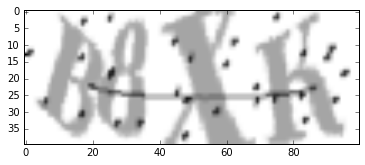

In [70]:
plt.imshow(X_train[1].reshape((40, 100)), cmap='gray')

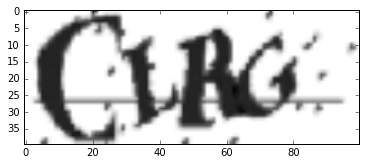

In [62]:
ac

0.0

In [117]:
type(y_train)

numpy.ndarray

In [196]:
np.concatenate((img2, img.reshape((40, 100, 1))), axis =2).shape

(40, 100, 3)

In [205]:
X = np.empty((40, 100, 1))

In [207]:
np.concatenate((img2, X), axis =2).shape

(40, 100, 3)